# Selective Capacitated Fair Pickup and Delivery Problem - Part II


## 0.) Introduction & setup

### Code Setup

In [203]:
from src.instance import Instance
from src.blabla import *
import os
import numpy as np
import copy

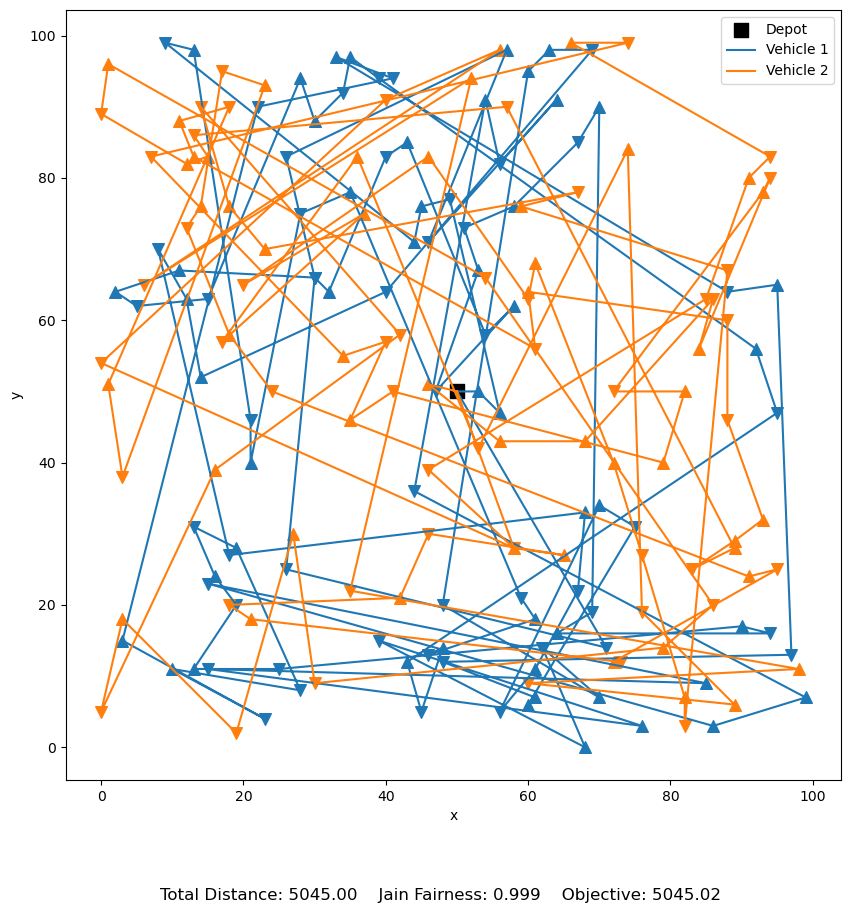

In [47]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)
plot_routes(aaa, routes)

## 1.) Implementing two algorithms

## Adaptive Large Neighborhood Search

We start by defining a class for our route representation

In [121]:
class Route:
    def __init__(self, instance):
        self.instance = instance
        self.capacity = instance.C

        self.nodes = []              # sequence of pickup/delivery node IDs
        self.requests = set()        # request IDs served by this route

        self.load_profile = []      # load after each node
        self.min_slack = instance.C    # min remaining capacity (thightest point along the route)
        self.distance = 0.0          # route length

    def recompute(self):
        load = 0
        self.load_profile = []
        self.min_slack = self.capacity

        for node in self.nodes:
            if node <= self.instance.n:
                load += self.instance.requests[node - 1]["demand"]
            else:
                load -= self.instance.requests[node - self.instance.n - 1]["demand"]

            if load < 0 or load > self.capacity:
                raise ValueError("Infeasible route")

            self.load_profile.append(load)
            self.min_slack = min(self.min_slack, self.capacity - load)
        self.distance = get_total_distance(self.instance, self.nodes)

    def load_from_array(self, route):
        # this function assumes valid input, because the input will mainly come from algorithms that are already tested and tried out
        self.nodes = route
        self.requests = {i for i in route if 1 <= i <= self.instance.n}
        self.recompute()

    def copy(self):
        return copy.deepcopy(self)

    def remove_request(self, req_id):
        if not req_id in self.requests:
            raise Exception("req_id not in this route!")
        self.nodes = [n for n in self.nodes if n != req_id and n != (req_id + self.instance.n)]
        self.requests.remove(req_id)
        self.recompute()
        #print("removed request ", req_id)

    def try_insert_request(self, req_id, pick_up_idx_pos, drop_off_idx_pos):
        #print(f"trying to pick up request {req_id} at position {pick_up_idx_pos} and drop it off at {drop_off_idx_pos}")
        # we start counting with 0!!!!
        if req_id > self.instance.n or req_id in self.requests:
            #raise Exception("Invalid req id!")
            return None
        if drop_off_idx_pos < pick_up_idx_pos:
            #raise Exception("drop off before pick up!")
            return None
        preliminary_route = self.nodes.copy()
        preliminary_route.insert(pick_up_idx_pos, req_id)
        preliminary_route.insert(drop_off_idx_pos + 1, req_id + self.instance.n)
        preliminary_load = 0
        preliminary_load_profile = []
        preliminary_min_slack = self.capacity
        for idx in preliminary_route:   # can be made more efficient I know
            if idx <= self.instance.n:
                preliminary_load += self.instance.requests[idx - 1]["demand"] # fucking off-by-one
                if (self.instance.C - preliminary_load) <= preliminary_min_slack:
                    preliminary_min_slack = self.instance.C - preliminary_load
                if preliminary_load > self.instance.C:
                    return None
            else:
                preliminary_load -= self.instance.requests[idx - self.instance.n - 1]["demand"]
                if preliminary_load < 0:
                    return None
            preliminary_load_profile.append(preliminary_load)
        #self.load_profile = preliminary_load_profile
        #self.min_slack = preliminary_min_slack
        #self.nodes = preliminary_route
        new_distance = get_total_distance(self.instance, preliminary_route)
        return new_distance - self.distance

    def insert_request(self, req_id, p_pos, d_pos):
        #print(f"Picking up req {req_id} at {p_pos} and dropping it off at {d_pos}")
        delta = self.try_insert_request(req_id, p_pos, d_pos)
        if delta is not None:
            pickup = req_id
            dropoff = req_id + self.instance.n

            self.nodes.insert(p_pos, pickup)
            self.nodes.insert(d_pos + 1, dropoff)
            self.requests.add(req_id)
            self.recompute()

    def marginal_cost(self, req_id):
        original_distance = self.distance
        temp_nodes = [n for n in self.nodes if n != req_id and n != req_id  + self.instance.n]
        new_distance = get_total_distance(self.instance, temp_nodes)
        return original_distance - new_distance


In [49]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)

r = Route(aaa)
r.load_from_array(routes[0])
print(len(r.nodes))
print(r.load_profile)
print(r.try_insert_request(3, 1, 1))
r.insert_request(3, 1, 1)
print(r.load_profile)

98
[29, 79, 50, 73, 98, 48, 86, 48, 80, 48, 67, 44, 78, 59, 76, 51, 89, 55, 81, 43, 71, 54, 76, 97, 71, 43, 63, 90, 63, 96, 76, 97, 64, 84, 64, 94, 64, 98, 64, 92, 70, 97, 69, 91, 64, 96, 74, 93, 72, 96, 64, 93, 72, 91, 72, 48, 88, 59, 100, 81, 41, 64, 91, 64, 84, 64, 84, 64, 82, 59, 18, 48, 93, 63, 45, 71, 91, 65, 84, 64, 91, 46, 79, 52, 82, 52, 77, 96, 71, 100, 71, 100, 67, 96, 77, 58, 29, 0]
129
[29, 57, 29, 79, 50, 73, 98, 48, 86, 48, 80, 48, 67, 44, 78, 59, 76, 51, 89, 55, 81, 43, 71, 54, 76, 97, 71, 43, 63, 90, 63, 96, 76, 97, 64, 84, 64, 94, 64, 98, 64, 92, 70, 97, 69, 91, 64, 96, 74, 93, 72, 96, 64, 93, 72, 91, 72, 48, 88, 59, 100, 81, 41, 64, 91, 64, 84, 64, 84, 64, 82, 59, 18, 48, 93, 63, 45, 71, 91, 65, 84, 64, 91, 46, 79, 52, 82, 52, 77, 96, 71, 100, 71, 100, 67, 96, 77, 58, 29, 0]


In [180]:
class Solution:
    def __init__(self, instance):
        self.instance = instance
        self.routes = []

        self.unserved_requests = set(r["index"] for r in instance.requests)

        self.total_cost = 0.0
        self.total_dist = 0.0
        self.fairness = 0.0

        # Fast lookup
        self.request_to_route = {} # tells us in which route we can find which request

    def load_from_arrays(self, routes):
        self.total_cost, self.total_dist, self.fairness = 0.0, 0.0, 0.0 # resetting everything
        self.unserved_requests = set(r["index"] for r in self.instance.requests)
        self.routes = []
        assert len(routes) == self.instance.n_k
        for r_idx, r in enumerate(routes):
            route = Route(self.instance)
            route.load_from_array(r)
            self.routes.append(route)
            self.total_dist += route.distance
            for req in route.requests:
                self.unserved_requests.remove(req)
                self.request_to_route[req] = r_idx
        self.fairness = get_Jain_fairness(self.instance, routes)
        self.total_cost = objective_function(self.instance, routes)

    def copy(self):
        return copy.deepcopy(self)

    def recompute_cost(self):
        self.total_cost, self.total_dist, self.fairness = 0.0, 0.0, 0.0 # resetting everything
        self.unserved_requests = set(r["index"] for r in self.instance.requests)
        #self.request_to_route = {} ToDo: reload requests_to_route!
        routes_as_array = []
        for route in self.routes:
            route.recompute()
            self.total_dist += route.distance
            routes_as_array.append(route.nodes)
            for req in route.requests:
                self.unserved_requests.remove(req)
        self.fairness = get_Jain_fairness(self.instance,routes_as_array)
        self.total_cost = objective_function(self.instance, routes_as_array)
        assert self.is_feasible()
        assert len(self.routes) == self.instance.n_k

    def is_feasible(self):
        # checking first condition - The vehicle capacity must never be exceeded at any point along the route
        # since all routes are already checked, we can assume this is true
        # checking second condition -  Each served request must be handled in its entirety by a single vehicle.
        # based on the design of the Route class, we also assume this is true
        # thirdly, at least gamma requests have to be served
        if len(self.unserved_requests) + self.instance.gamma <= self.instance.n:
            return True
        else:
            return False

    def plot(self):
        routes_as_array = [r.nodes for r in self.routes]
        plot_routes(self.instance, routes_as_array)

    def save_to_file(self, instance_file_path, output_dir="solutions"):
        """
        Save solution in the assignment-specified format.

        Format:
        <instance_name>
        R1,1 R1,2 ... R1,|R1|
        R2,1 R2,2 ... R2,|R2|
        ...
        """

        os.makedirs(output_dir, exist_ok=True)

        # extract instance name (no path, no extension)
        instance_name = os.path.splitext(os.path.basename(instance_file_path))[0]

        out_file = os.path.join(output_dir, instance_name + "_solution.txt")

        with open(out_file, "w") as f:
            # first line: instance name
            f.write(instance_name + "\n")

            # each route on one line
            for route in self.routes:
                # IMPORTANT: adapt this depending on your Route structure
                # This should be the ordered list of request-location indices
                nodes = route.nodes

                if len(nodes) == 0:
                    f.write("\n")
                    continue

                line = " ".join(str(node) for node in nodes)
                f.write(line + "\n")

        print(f"Saved solution to {out_file}")

In [51]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)
s = Solution(aaa)
s.load_from_arrays(routes)
s.recompute_cost()

### Destroy operators

In [122]:
def random_removal(solution, q):
    removed = set()
    all_requests = list(
        req for r in solution.routes for req in r.requests
    )
    random.shuffle(all_requests)

    for req in all_requests[:q]:
        route_idx = solution.request_to_route[req]
        del solution.request_to_route[req]
        route = solution.routes[route_idx]
        route.remove_request(req)
        solution.unserved_requests.add(req)
        removed.add(req)

    return removed

In [123]:
random_removal(s, 3)

removed request  92
removed request  27
removed request  63


{27, 63, 92}

In [124]:
def worst_removal(solution, q):
    candidates = []

    for route in solution.routes:
        for req in route.requests:
            delta = route.marginal_cost(req)
            candidates.append((delta, req))

    candidates.sort(reverse=True)
    removed = set()

    for _, req in candidates[:q]:
        route_idx = solution.request_to_route[req]
        del solution.request_to_route[req]
        route = solution.routes[route_idx]
        route.remove_request(req)
        solution.unserved_requests.add(req)
        removed.add(req)

    return removed

In [125]:
worst_removal(s, 1)

removed request  46


{46}

In [126]:
def shaw_removal(solution, q):
    removed = set()
    all_requests = list(
        req for r in solution.routes for req in r.requests
    )
    seed = random.choice(all_requests)
    removed.add(seed)

    def relatedness(r1, r2):
        #print(f"request 1: {r1}, request2: {r2}")
        r1_idx = int(r1 - 1)
        r2_idx = int(r2 - 1)
        p1 = solution.instance.requests[r1_idx]["pick_up"]
        p2 = solution.instance.requests[r2_idx]["pick_up"]
        return a(p1, p2)


    while len(removed) < q:
        candidates = [
            r for r in all_requests if r not in removed
        ]
        candidates.sort(key=lambda r: relatedness(seed, r))
        removed.add(candidates[0])

    for req in removed:
        route_idx = solution.request_to_route[req]
        route = solution.routes[route_idx]
        del solution.request_to_route[req]
        route.remove_request(req)
        solution.unserved_requests.add(req)

    return removed

In [127]:
shaw_removal(s, 10)

removed request  37
removed request  8
removed request  12
removed request  76
removed request  21
removed request  86
removed request  87
removed request  61
removed request  94
removed request  95


{8, 12, 21, 37, 61, 76, 86, 87, 94, 95}

### Repair Operators

In [128]:
def best_insertion_for_route(route, req, max_gap=5):
    best_delta = None
    best_pos = None

    L = len(route.nodes)

    for p in range(L + 1):
        for d in range(p + 1, min(p + max_gap, L + 2)):
            delta = route.try_insert_request(req, p, d)
            if delta is not None:
                if best_delta is None or delta < best_delta:
                    best_delta = delta
                    best_pos = (p, d)

    return best_delta, best_pos


def greedy_repair(solution, max_gap=5):
    while len(solution.unserved_requests) > solution.instance.n - solution.instance.gamma:
        best = None

        for req in list(solution.unserved_requests):
            for route_idx, route in enumerate(solution.routes):
                delta, pos = best_insertion_for_route(route, req, max_gap)
                if pos is not None:
                    if best is None or delta < best[0]:
                        best = (delta, req, route_idx, pos)

        if best is None:
            break

        _, req, route_idx, (p, d) = best
        solution.routes[route_idx].insert_request(req, p, d)
        solution.unserved_requests.remove(req)
        solution.request_to_route[req] = route_idx


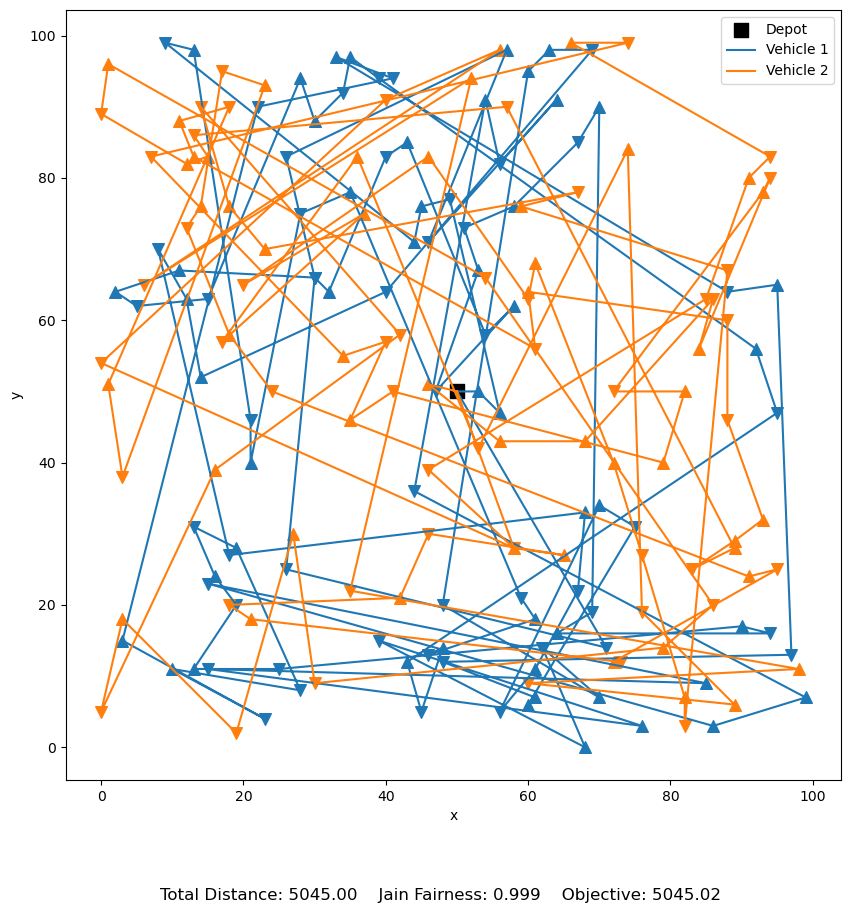

In [129]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
s = Solution(instance)
s.load_from_arrays(nearest_neighbor_heuristic(instance))
s.plot()

In [100]:
for i in range(10):
    worst_removal(s, 4)
    greedy_repair(s)
s.plot()

removed request  32
removed request  63
removed request  68
removed request  83
removed request  20
removed request  98
removed request  9
removed request  55
trying to pick up request 4 at position 0 and drop it off at 1
trying to pick up request 4 at position 0 and drop it off at 2
trying to pick up request 4 at position 0 and drop it off at 3
trying to pick up request 4 at position 0 and drop it off at 4
trying to pick up request 4 at position 1 and drop it off at 2
trying to pick up request 4 at position 1 and drop it off at 3
trying to pick up request 4 at position 1 and drop it off at 4
trying to pick up request 4 at position 1 and drop it off at 5
trying to pick up request 4 at position 2 and drop it off at 3
trying to pick up request 4 at position 2 and drop it off at 4
trying to pick up request 4 at position 2 and drop it off at 5
trying to pick up request 4 at position 2 and drop it off at 6
trying to pick up request 4 at position 3 and drop it off at 4
trying to pick up requ

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



trying to pick up request 62 at position 0 and drop it off at 1
trying to pick up request 62 at position 0 and drop it off at 2
trying to pick up request 62 at position 0 and drop it off at 3
trying to pick up request 62 at position 0 and drop it off at 4
trying to pick up request 62 at position 1 and drop it off at 2
trying to pick up request 62 at position 1 and drop it off at 3
trying to pick up request 62 at position 1 and drop it off at 4
trying to pick up request 62 at position 1 and drop it off at 5
trying to pick up request 62 at position 2 and drop it off at 3
trying to pick up request 62 at position 2 and drop it off at 4
trying to pick up request 62 at position 2 and drop it off at 5
trying to pick up request 62 at position 2 and drop it off at 6
trying to pick up request 62 at position 3 and drop it off at 4
trying to pick up request 62 at position 3 and drop it off at 5
trying to pick up request 62 at position 3 and drop it off at 6
trying to pick up request 62 at position

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [131]:
def regret_3_repair(solution, max_gap = 5):
    while len(solution.unserved_requests) > solution.instance.n - solution.instance.gamma: # while we don't serve at least gamma requests
        best_req = None
        best_regret = -float("inf")
        best_route = None

        for req in solution.unserved_requests:
            costs = []  # collect the "cost" of each unserved request
            #print(f"req: {req}")

            for route in solution.routes:
                # try_insert_request(self, req_id, pick_up_idx_pos, drop_off_idx_pos):
                L = len(route.nodes)
                for p in range(L + 1):
                    for d in range(p + 1, min(p + max_gap, L + 2)):
                        delta = route.try_insert_request(req,p, d)
                        if delta is not None:
                            costs.append((delta, route, p, d)) # the "cost" is the delta in the objectieve function we would achieve by inserting at this position

            if len(costs) < 1: # we skip the sorting it there are not at least two entries
                continue

            costs.sort(key=lambda x: x[0]) # we sort the costs per delta
            c1 = costs[0][0] # cost of the best solution
            c3 = costs[2][0] if len(costs) >= 3 else costs[-1][0] # choose the second on eor else the third one if we don't have enough entries
            regret = c3 - c1 # regret is always positive, hsa the largest possible value if c1 is really _much_ better than c3, -> tells us "how much" c1 is better than c3

            if regret > best_regret: # instead of inserting the request where we would get instantly most optimal objective score, we insert it where the difference in the objective score to the other possiblilities is the highest
                best_regret = regret
                best_req = req
                best_route = costs[0][1]
                best_p = costs[0][2]
                best_d = costs[0][3]

        if best_req is None:
            raise Exception("No best insertion found")
            break

        # insert_request(self, req_id, p_pos, d_pos):
        best_route.insert_request(best_req, best_p, best_d)
        solution.unserved_requests.remove(best_req)
        route_idx = solution.routes.index(best_route)
        solution.request_to_route[best_req] = route_idx



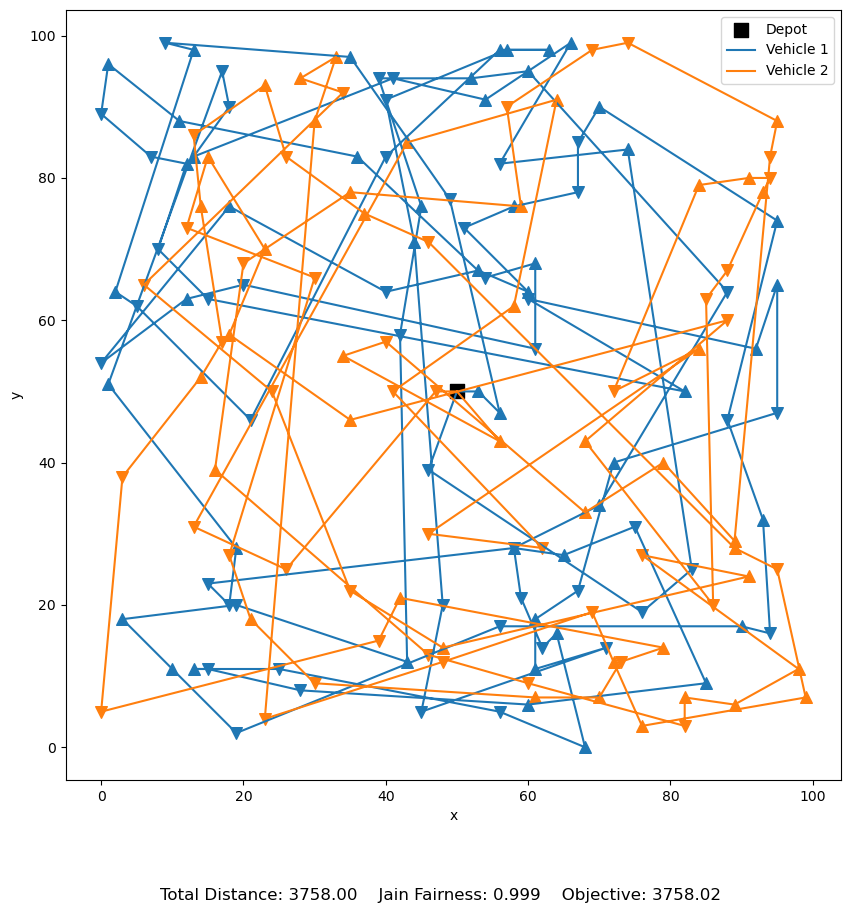

In [150]:
for i in range(5):
    shaw_removal(s, 10)
    regret_3_repair(s)
s.plot()

### === ALNS ===

In [195]:
class OperatorPool:
    def __init__(self, operators):
        self.ops = operators
        self.weights = [1.0] * len(operators)
        self.scores = [0.0] * len(operators)

    def select(self):
        return random.choices(
            range(len(self.ops)),
            weights=self.weights,
            k=1
        )[0]

    def update(self, idx, reward):
        self.scores[idx] += reward

    def adapt(self, rho=0.1):
        for i in range(len(self.weights)):
            self.weights[i] = (
                (1 - rho) * self.weights[i] + rho * self.scores[i]
            )
            self.scores[i] = 0.0

In [196]:
@dataclass
class ALNSParams:
    T0: float
    cooling: float
    destroy_fraction: int
    rho: float
    reward_best: float
    reward_accept: float
    reward_reject: float
    regret_k: int
    max_gap: int

In [197]:
def alns(instance, initial_solution, params, iters=100):
    def accept(new, current, temperature):
        if new.total_cost < current.total_cost:
            return True
        delta = new.total_cost - current.total_cost
        return random.random() < math.exp(-delta / temperature)

    destroy_ops = OperatorPool([
        lambda s: random_removal(s, q=params.destroy_fraction),
        lambda s: worst_removal(s, q=params.destroy_fraction),
        lambda s: shaw_removal(s, q=params.destroy_fraction),
    ])

    repair_ops = OperatorPool([
        lambda s: greedy_repair(s, max_gap=params.max_gap),
        lambda s: regret_3_repair(s, max_gap = params.max_gap),
    ])

    current = initial_solution
    best = current.copy()
    T = params.T0

    for it in range(iters):
        new = current.copy()

        d = destroy_ops.select()
        r = repair_ops.select()

        destroy_ops.ops[d](new)
        repair_ops.ops[r](new)

        new.recompute_cost()

        if not new.is_feasible():
            continue

        if accept(new, current, T):
            current = new
            reward = params.reward_accept

            if new.total_cost < best.total_cost:
                best = new.copy()
                reward = params.reward_best
        else:
            reward = params.reward_reject

        destroy_ops.update(d, reward)
        repair_ops.update(r, reward)

        if it % 100 == 0:
            destroy_ops.adapt()
            repair_ops.adapt()
            T *= params.cooling  # cooling

    return best

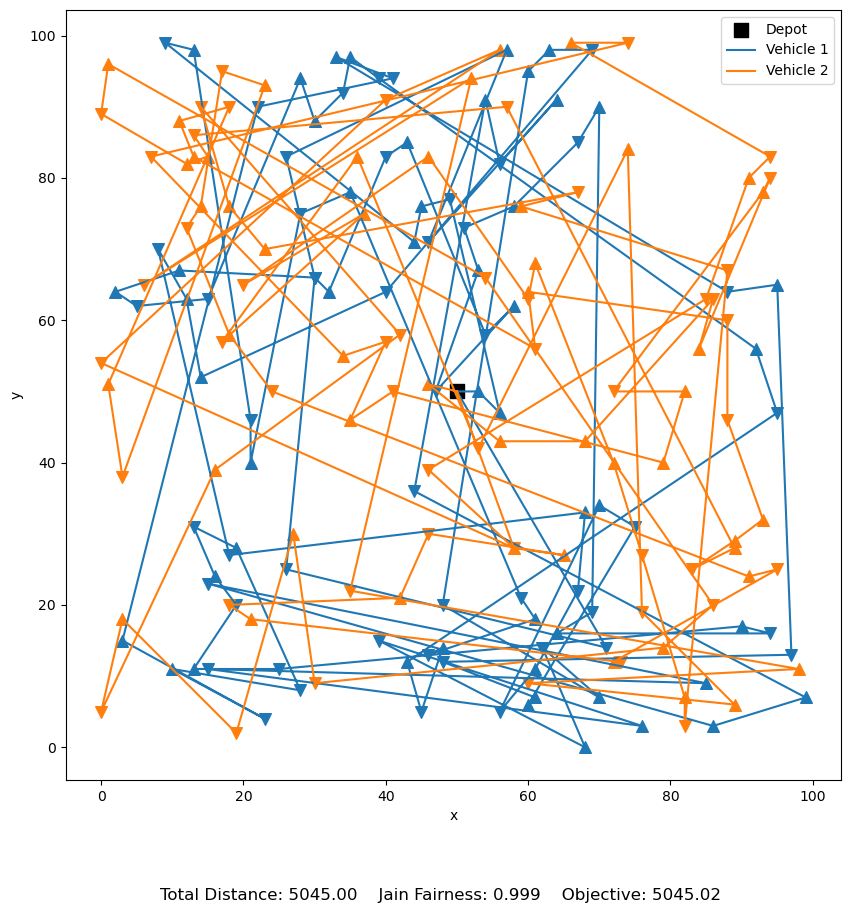

In [198]:
params = ALNSParams(
    T0=25.0,          # Example: Initial temperature
    cooling=0.95,      # Example: Cooling rate
    destroy_fraction=10,  # Example: Destroy 30% of nodes
    rho=0.1,           # Example: Reaction factor
    reward_best=5.0,   # Example: Reward for finding a new best solution
    reward_accept=1.0, # Example: Reward for accepting a solution
    reward_reject=-1.0, # Example: Reward for rejecting a solution
    regret_k=3,
    max_gap = 10)
s0 = Solution(instance)
s0.load_from_arrays(nearest_neighbor_heuristic(instance))
s0.recompute_cost()
s0.plot()

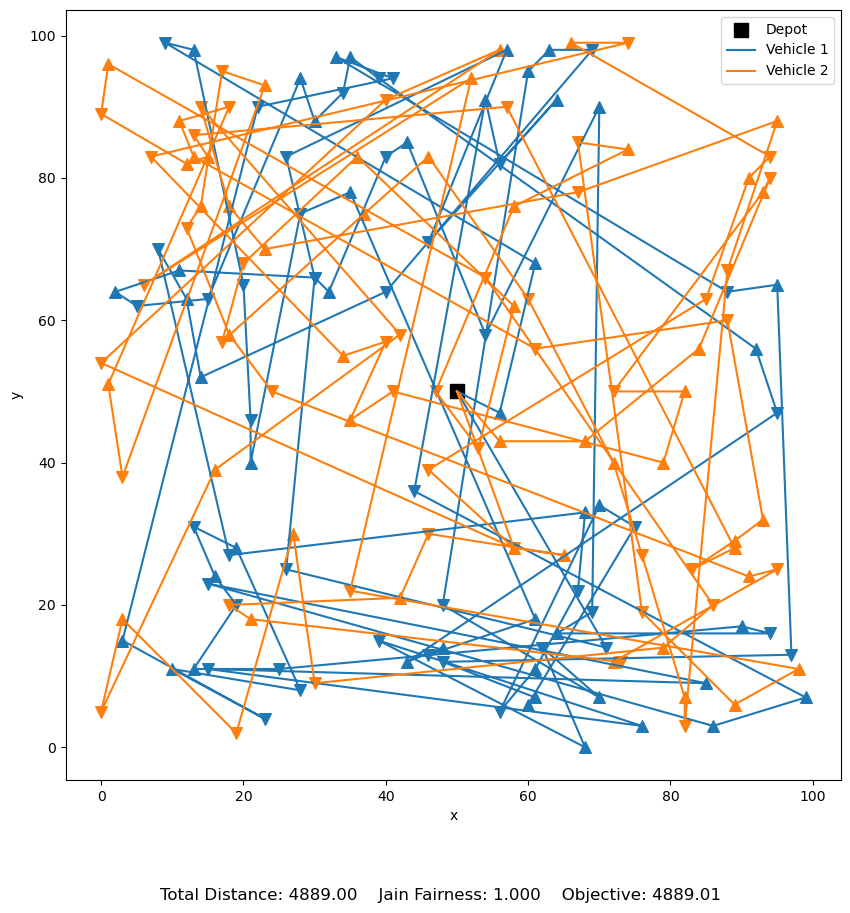

In [207]:
new_s = alns(instance, s0,params ,iters = 10)
new_s.plot()

In [208]:
new_s.routes[0].nodes
new_s.save_to_file("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt", "solutions")

Saved solution to solutions/instance61_nreq100_nveh2_gamma91_solution.txt


In [209]:
np.sum(new_s.routes[0].load_profile) / (len(new_s.routes[0].nodes) * instance.C)

np.float64(0.6790909090909091)

## 2.) Experimenting with different fairness mesaures

### Min-Max Fairness

### Gini coefficient

## 3.) Tuning our algorithms

## 4.) Testing our algortihms

## 5.) Comparing algorithms